# Calibración y análisis — Modelo de Tanques

In [1]:

import pandas as pd
import numpy as np
from tank_model import TankModel, ModelConfig, nse, kge, bias_pct
from tank_model.parameters import Parameters
from tank_model.io import load_csv, subset_period, tag_hydrology
from tank_model.et import ensure_pet

# 1) Cargar datos
df = load_csv('../data/example_forcing.csv')
df.head()


,P_mm,PET_mm
date,,
2020-01-01,0,3
2020-01-02,5,3
2020-01-03,2,3
2020-01-04,0,3
2020-01-05,0,3


<Axes: title={'center': 'P y PET'}, xlabel='date'>

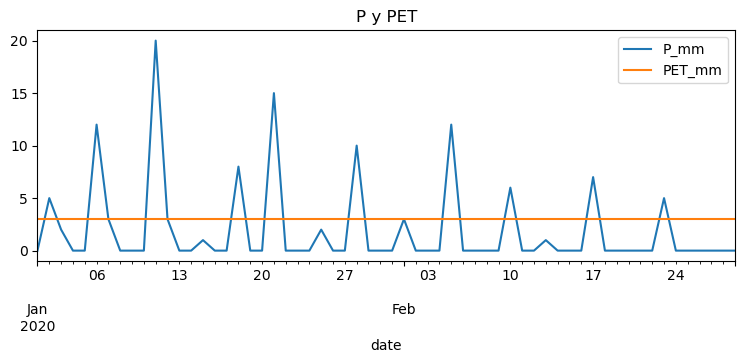

In [2]:

# 2) Asegurar PET con Cenicafé (si tienes Tmean_C y Rs_MJ_m2_d en tu CSV)
# df = ensure_pet(df, method='cenicafe', a=0.0135, b=17.78)
# Para el ejemplo ya existe PET_mm:
df = ensure_pet(df, method='column')
df[['P_mm','PET_mm']].plot(title='P y PET', figsize=(9,3))


<Axes: title={'center': 'Qout (mm/dt)'}, xlabel='date'>

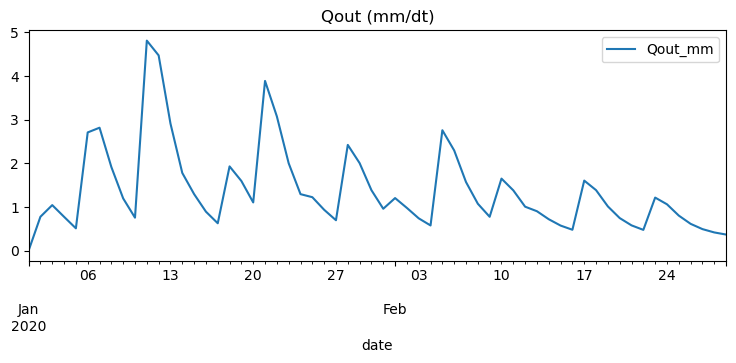

In [3]:

# 3) Configurar y correr
cfg = ModelConfig(dt_hours=24.0, area_km2=5.0, route=True)
p = Parameters()
m = TankModel(p, cfg)
sim = m.run(df)
sim[['Qout_mm']].plot(title='Qout (mm/dt)', figsize=(9,3))


In [4]:

# 4) Análisis seco/húmedo y métricas por régimen
reg = tag_hydrology(df, col='P_mm', dry_q=0.25, wet_q=0.75)
sim['regime'] = reg
sim.groupby('regime')['Qout_mm'].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
dry,18.0,0.663712,0.289235,0.000000,0.481900,0.620282,0.870264,1.215615
normal,26.0,1.246984,0.517365,0.510838,0.807719,1.089557,1.589492,2.423049
wet,16.0,2.432465,1.216629,0.755324,1.295137,2.355621,2.954308,4.813170


In [5]:

# 5) NSE/KGE por subperíodos (ejemplo sintético con obs = sim + ruido)
obs = sim['Qout_mm'] * (1 + np.random.normal(0, 0.1, size=len(sim)))
print('NSE total:', nse(obs, sim['Qout_mm']))
for r in ['dry','normal','wet']:
    mask = sim['regime'] == r
    print(r, 'NSE=', nse(obs[mask], sim.loc[mask,'Qout_mm']))


NSE total: 0.9703461537314315
dry NSE= 0.9345906371670456
normal NSE= 0.9436993682455601
wet NSE= 0.9426917162472523
